# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
#Some helper function to plot images
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## ResNet-34

In [ ]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

# Class ResidualUnit is the implementation of Skip connection. 
# In Skip Connection (part of residual learning), the structure includes 
# conv layer (kernel =3) + BN + Relu + conv layer (kernel=3)
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
# Build a base Sequential model from Keras libraru
model = keras.models.Sequential()

# Add convolution layers to it
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
# Look at your model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_36 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_16 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_17 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_18 (ResidualUn (None, 56, 56, 64)       

## Using a Pretrained Model

In [ ]:
# Using resnet50 implementation from Keras library
model = keras.applications.resnet50.ResNet50(weights="imagenet")

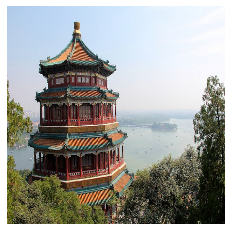

In [ ]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])


images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


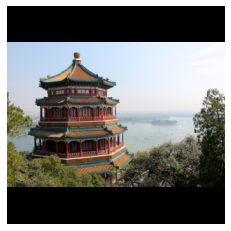

In [ ]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

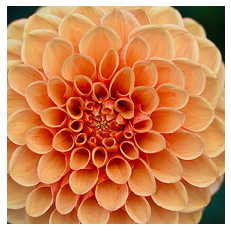

In [ ]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[1])
plt.show()

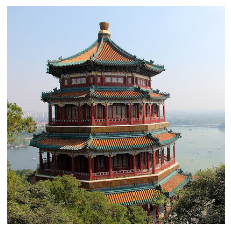

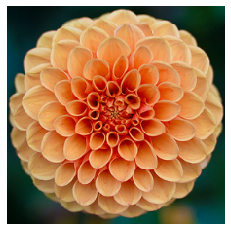

In [ ]:
# Lets take a look at first and second images in the dataset
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

## We want to use pretrain models to see if we can predict above images correctly. We are expecting to predict Palace and Flower

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [ ]:
Y_proba

array([[4.4473869e-11, 3.6248854e-10, 4.9862769e-10, ..., 1.6187414e-11,
        4.7147051e-09, 6.8202138e-11],
       [3.0196009e-07, 3.6119029e-06, 2.0487936e-07, ..., 3.8420450e-05,
        2.2673299e-05, 3.1660060e-05]], dtype=float32)

In [ ]:
Y_proba.shape

(2, 1000)

# Lets decode predictions and see what they are

In [ ]:
# Generating top 5 guess. 
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=5)

for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%
  n02980441 - castle       0.81%
  n09332890 - lakeside     0.17%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%
  n03443371 - goblet       3.84%
  n03916031 - perfume      3.31%



## Have some fun!

Go through TensorFlow's [Style Transfer tutorial](https://homl.info/styletuto). It is a fun way to generate art using Deep Learning._
